In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

%matplotlib inline

plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['figure.dpi'] = 100 
plt.style.use('ggplot')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
clinical_df = pd.read_csv('../data/Clinical/SKCM_DATA_Clinical.csv', index_col = 0)
clinical_df.set_index('submitter_id',inplace=True)
clinical_df = clinical_df[~clinical_df.index.duplicated(keep='first')]
print(clinical_df.shape)
clinical_df.head()

(470, 73)


,synchronous_malignancy,ajcc_pathologic_stage,tumor_stage,days_to_diagnosis,created_datetime,last_known_disease_status,tissue_or_organ_of_origin,days_to_last_follow_up,primary_diagnosis,age_at_diagnosis,updated_datetime,prior_malignancy,year_of_diagnosis,prior_treatment,state,days_to_last_known_disease_status,ajcc_staging_system_edition,ajcc_pathologic_t,days_to_recurrence,morphology,ajcc_pathologic_n,ajcc_pathologic_m,classification_of_tumor,diagnosis_id,icd_10_code,site_of_resection_or_biopsy,tumor_grade,progression_or_recurrence,cigarettes_per_day,alcohol_history,exposure_id,years_smoked,weight,alcohol_intensity,height,bmi,race,gender,ethnicity,vital_status,age_at_index,days_to_birth,year_of_birth,demographic_id,year_of_death,days_to_death,treatments_pharmaceutical_treatment_intent_type,treatments_pharmaceutical_treatment_id,treatments_pharmaceutical_treatment_type,treatments_pharmaceutical_therapeutic_agents,treatments_pharmaceutical_treatment_or_therapy,treatments_pharmaceutical_days_to_treatment_end,treatments_pharmaceutical_days_to_treatment_start,treatments_pharmaceutical_regimen_or_line_of_therapy,treatments_pharmaceutical_treatment_effect,treatments_pharmaceutical_initial_disease_status,treatments_pharmaceutical_treatment_anatomic_site,treatments_pharmaceutical_treatment_outcome,treatments_radiation_treatment_intent_type,treatments_radiation_treatment_id,treatments_radiation_treatment_type,treatments_radiation_therapeutic_agents,treatments_radiation_treatment_or_therapy,treatments_radiation_days_to_treatment_end,treatments_radiation_days_to_treatment_start,treatments_radiation_regimen_or_line_of_therapy,treatments_radiation_treatment_effect,treatments_radiation_initial_disease_status,treatments_radiation_treatment_anatomic_site,treatments_radiation_treatment_outcome,bcr_patient_barcode,disease,sample_type
submitter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-BF-A1PZ,No,Stage IIB,stage iib,0.0,NaN,not reported,"Skin, NOS",853.0,"Malignant melanoma, NOS",26240.0,2019-08-08T17:29:28.028808-05:00,no,2010.0,No,released,NaN,7th,T4a,NaN,8720/3,N0,M0,not reported,58877acc-4579-5cbc-b0d7-a1a60f9d9360,C44.9,"Skin, NOS",not reported,not reported,NaN,Not Reported,3224ecb7-496a-52b2-bb06-79faa29362bd,NaN,56.0,NaN,163.0,21.077195,white,female,not hispanic or latino,Alive,71.0,-26240.0,1939.0,a951cc17-255b-52c1-8b16-06a110a1f256,NaN,NaN,NaN,a738fcf5-fbc5-54ae-9aca-a474c981980b,"Pharmaceutical Therapy, NOS",NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,606f9d0c-405a-51a7-83b6-850abd587e3e,"Radiation Therapy, NOS",NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TCGA-BF-A1PZ,SKCM,Primary Tumor
TCGA-HR-A5NC,No,NaN,not reported,0.0,NaN,not reported,"Skin, NOS",0.0,"Malignant melanoma, NOS",32872.0,2019-08-08T17:32:34.888606-05:00,no,NaN,No,released,NaN,6th,T4,NaN,8720/3,NX,M0,not reported,0a71cde5-a658-58fa-8f7d-5b461ed5ba0d,C44.5,Skin of trunk,not reported,not reported,NaN,Not Reported,6f513e61-8df3-557c-8970-79ed709b496c,NaN,NaN,NaN,152.0,NaN,not reported,female,not reported,Alive,90.0,-32872.0,NaN,2bf37b46-b292-5211-8308-8e7478e13fac,NaN,NaN,NaN,0a4cb88c-3f7d-58b9-861e-4e99f1e79879,"Pharmaceutical Therapy, NOS",NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5bec652c-8fcf-5693-ba5f-a4c685cfbafd,"Radiation Therapy, NOS",NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TCGA-HR-A5NC,SKCM,Primary Tumor
TCGA-EE-A183,No,Stage 0,stage 0,0.0,NaN,not reported,"Skin, NOS",NaN,"Malignant melanoma, NOS",17788.0,2019-08-08T17:31:00.525265-05:00,no,2007.0,No,released,NaN,6th,Tis,NaN,8720/3,N0,M0,not reported,ad50acaa-3906-5038-a738-b1df7206c3fb,C77.3,Lymph nodes of axilla or arm,not reported,not reported,NaN,Not Reported,5e224124-5dc5-5e14-a52d-aebafebbdae1,NaN,NaN,NaN,NaN,NaN,white,male,not hispanic or latino,Dead,48.0,-17788.0,1959.0,f890ebbe-7014-5316-9088-92d883eb8050,2009.0,818.0,NaN,2ac616a8-887f-53c2-a8ea-ae66c6d48a02,"Pharmaceutical Therapy, NOS",NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f7775347-3381-519c-b1fd-c61f6d261154,"Radiation Therapy, NOS"

In [3]:
rnaseq_df = pd.read_csv('../data/RNASeq/SKCM_DATA_RNASeq.csv', index_col = 0)
print(rnaseq_df.shape)
rnaseq_df.head()

(19947, 473)


,TCGA-W3-AA21-06A-11R-A38C-07,TCGA-ER-A19F-06A-11R-A18S-07,TCGA-BF-AAP4-01A-11R-A40A-07,TCGA-EE-A2MF-06A-11R-A21D-07,TCGA-EE-A2MJ-06A-11R-A18S-07,TCGA-D3-A8GM-06A-11R-A37K-07,TCGA-GN-A26A-06A-11R-A18T-07,TCGA-EB-A3XE-01A-12R-A239-07,TCGA-DA-A1I0-06A-11R-A20F-07,TCGA-FR-A3R1-01A-11R-A239-07,TCGA-EE-A3AA-06A-11R-A18S-07,TCGA-EE-A3AF-06A-11R-A18S-07,TCGA-D9-A4Z6-06A-12R-A266-07,TCGA-EE-A2MQ-06A-11R-A18S-07,TCGA-FS-A1YX-06A-11R-A18T-07,TCGA-D3-A8GC-06A-11R-A37K-07,TCGA-GN-A8LL-06A-21R-A37K-07,TCGA-D3-A1Q7-06A-11R-A18T-07,TCGA-ER-A19P-06A-11R-A18S-07,TCGA-YG-AA3N-01A-11R-A38C-07,TCGA-D3-A1QB-06A-11R-A18T-07,TCGA-DA-A960-01A-11R-A37K-07,TCGA-FS-A4FB-06A-11R-A266-07,TCGA-DA-A1HV-06A-21R-A18S-07,TCGA-ER-A3PL-06A-11R-A239-07,TCGA-FS-A1Z7-06A-11R-A18T-07,TCGA-RP-A693-06A-13R-A311-07,TCGA-XV-A9W5-01A-11R-A38C-07,TCGA-FS-A4F4-06A-12R-A266-07,TCGA-LH-A9QB-06A-11R-A38C-07,TCGA-EE-A2GB-06A-11R-A18T-07,TCGA-D3-A3MR-06A-11R-A21D-07,TCGA-ER-A42L-06A-11R-A24X-07,TCGA-EE-A2M8-06A-12R-A18S-07,TCGA-FS-A1Z4-06A-11R-A18T-07,TCGA-D9-A6EA-06A-11R-A311-07,TCGA-D3-A5GU-06A-11R-A27Q-07,TCGA-EE-A29X-06A-11R-A18T-07,TCGA-EB-A4IS-01A-21R-A266-07,TCGA-GF-A769-01A-32R-A32P-07,TCGA-EE-A2GM-06B-11R-A18S-07,TCGA-W3-AA1V-06B-11R-A40A-07,TCGA-EB-A4XL-01A-11R-A27Q-07,TCGA-EE-A3J8-06A-11R-A20F-07,TCGA-EE-A3JD-06A-11R-A20F-07,TCGA-ER-A19O-06A-11R-A18S-07,TCGA-D3-A1QA-06A-11R-A18T-07,TCGA-D3-A2J7-06A-11R-A18T-07,TCGA-EE-A20B-06A-11R-A18U-07,TCGA-ER-A19N-06A-11R-A18S-07,TCGA-EE-A2GT-06A-12R-A18S-07,TCGA-GN-A264-06A-11R-A18U-07,TCGA-FR-A726-01A-11R-A32P-07,TCGA-EB-A57M-01A-51R-A311-07,TCGA-FS-A4FC-06A-11R-A24X-07,TCGA-GN-A8LN-01A-11R-A37K-07,TCGA-BF-A9VF-01A-11R-A37K-07,TCGA-FS-A4F9-06A-11R-A24X-07,TCGA-D9-A3Z1-06A-11R-A239-07,TCGA-EB-A550-01A-61R-A27Q-07,TCGA-DA-A1IB-06A-11R-A18S-07,TCGA-EE-A29C-06A-21R-A18S-07,TCGA-FR-A728-01A-11R-A32P-07,TCGA-FS-A4F0-06A-11R-A24X-07,TCGA-EE-A2MI-06A-11R-A18U-07,TCGA-D3-A8GD-06A-11R-A37K-07,TCGA-WE-AAA0-06A-11R-A38C-07,TCGA-ER-A19S-06A-11R-A18U-07,TCGA-FR-A729-06A-11R-A352-07,TCGA-D3-A2JH-06A-11R-A18T-07,TCGA-EE-A182-06A-11R-A18T-07,TCGA-D3-A2JD-06A-11R-A18T-07,TCGA-QB-A6FS-06A-11R-A311-07,TCGA-EB-A5SF-01A-11R-A311-07,TCGA-YD-A9TA-06A-11R-A39D-07,TCGA-FR-A69P-06A-21R-A311-07,TCGA-EE-A2M6-06A-12R-A18S-07,TCGA-ER-A194-01A-11R-A18U-07,TCGA-FS-A1ZE-06A-11R-A18T-07,TCGA-WE-A8ZY-06A-11R-A37K-07,TCGA-EE-A2GS-06A-12R-A18S-07,TCGA-FR-A2OS-01A-11R-A21D-07,TCGA-D3-A5GO-06A-12R-A27Q-07,TCGA-EB-A1NK-01A-11R-A18T-07,TCGA-EB-A6QZ-01A-12R-A32P-07,TCGA-WE-A8ZQ-06A-41R-A37K-07,TCGA-EB-A5SH-06A-11R-A311-07,TCGA-ER-A199-06A-11R-A18T-07,TCGA-WE-A8ZM-06A-11R-A37K-07,TCGA-FR-A7UA-06A-32R-A352-07,TCGA-EB-A4OY-01A-11R-A266-07,TCGA-FS-A1ZY-06A-11R-A18S-07,TCGA-EE-A29S-06A-11R-A18T-07,TCGA-EE-A29Q-06A-11R-A18T-07,TCGA-FS-A1YW-06A-11R-A18T-07,TCGA-GN-A4U5-01A-11R-A32P-07,TCGA-ER-A3ES-06A-11R-A20F-07,TCGA-FR-A3YN-06A-11R-A239-07,TCGA-D9-A6EG-06A-12R-A32P-07,TCGA-EB-A6R0-01A-12R-A32P-07,TCGA-D3-A3CB-06A-11R-A18S-07,TCGA-D9-A4Z2-01A-11R-A24X-07,TCGA-FS-A1ZP-06A-11R-A18T-07,TCGA-FS-A1ZT-06A-11R-A18U-07,TCGA-HR-A2OG-06A-21R-A18U-07,TCGA-D3-A3BZ-06A-12R-A18S-07,TCGA-EB-A44R-06A-41R-A266-07,TCGA-YD-A9TB-06A-12R-A40A-07,TCGA-FW-A5DY-06A-11R-A311-07,TCGA-ER-A19C-06A-11R-A18S-07,TCGA-D3-A3C6-06A-12R-A18U-07,TCGA-ER-A2NC-06A-11R-A18T-07,TCGA-D3-A3C7-06A-11R-A18U-07,TCGA-BF-A3DJ-01A-11R-A20F-07,TCGA-D3-A2J6-06A-11R-A18T-07,TCGA-FS-A4F5-06A-11R-A266-07,TCGA-EE-A3JB-06A-11R-A21D-07,TCGA-D9-A1X3-06A-11R-A18S-07,TCGA-RP-A690-06A-11R-A311-07,TCGA-D3-A8GO-06A-11R-A37K-07,TCGA-D9-A4Z3-01A-11R-A266-07,TCGA-DA-A1I4-06A-11R-A18U-07,TCGA-FR-A7U9-06A-11R-A352-07,TCGA-ER-A19E-06A-11R-A18S-07,TCGA-EE-A3AD-06A-11R-A18S-07,TCGA-W3-AA1Q-06A-11R-A38C-07,TCGA-D3-A5GT-01A-12R-A311-07,TCGA-YD-A89C-06A-11R-A37K-07,TCGA-EE-A17Z-06A-11R-A18S-07,TCGA-XV-A9W2-01A-11R-A39D-07,TCGA-EB-A430-01A-11R-A24X-07,TCGA-D3-A3MU-06A-11R-A21D-07,TCGA-EE-A3JA-06A-11R-A20F-07,TCGA-EE-A29B-06A-11R-A18U-07,TCGA-BF-AAP6-01A-11R-A40A-07,TCGA-RP-A6K9-06A-41R-A352-07,TCGA-D3-A1Q5-06A-11R-A18T-07,TCGA-ER-A2NF-01A-11R-A18T-

In [4]:
X = rnaseq_df.T
X.index = [index[0:12] for index in X.index.values]
X.index.names = ['submitter_id']
print(X.shape)
print(X.index[X.index.duplicated()].unique())
X = X[~X.index.duplicated(keep='first')]
print(X.shape)
X.head()

(473, 19947)
Index(['TCGA-GN-A4U8', 'TCGA-ER-A2NF', 'TCGA-ER-A19T', 'TCGA-D3-A1QA'], dtype='object', name='submitter_id')
(469, 19947)


,A1BG,A2M,NAT1,NAT2,RP11-986E7.7,AADAC,AAMP,AANAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCB7,ABCF1,ABCA4,ABL1,AOC1,ABL2,ABO,ABR,ACAA1,ACACA,ACACB,ACADL,ACADM,ACADS,ACADSB,ACADVL,ACAT1,ACAT2,ASIC2,ASIC1,ACHE,ACLY,ACO1,ACR,ACO2,ACOX1,ACP1,ACP2,ACP5,ACPP,ACRV1,ACTA1,ACTA2,ACTG1,ACTC1,ACTG1,ACTG2,ACTN4,ACTL6A,ACTN1,ACTN2,ACTN3,ACVR1,ACVR1B,ACVR2A,ACVR2B,ACVRL1,ACY1,ACYP1,ACYP2,ADA,ADAM8,ADAM10,ADAR,ADARB1,ADARB2,ADCY1,ADCY2,ADCY3,ADCY5,ADCY6,ADCY7,ADCY8,ADCY9,ADCYAP1,ADCYAP1R1,ADD1,ADD2,ADD3,PLIN2,ADH1A,ADH1B,ADH1C,ADH4,ADH5,ADH6,ADH7,ADK,ADM,ADORA1,ADORA2A,ADORA2B,ADORA3,ADPRH,PARP1,PARP4,ADRA1D,ADRA1B,ADRA1A,ADRA2A,ADRA2B,ADRA2C,ADRB1,ADRB2,ADRB3,ADRBK1,ADRBK2,ADSL,ADSS,AP2A1,AP2A2,AP1B1,AP2B1,AP1G1,AEBP1,AES,CRISP1,AFG3L1P,AFM,AFP,AGA,ACAN,AGER,AGL,AGRP,JAG1,AGT,AGTR1,AGTR2,APLNR,AGXT,NR0B1,AHCY,AHR,AHSG,AIF1,AIM1,AK1,RP4-592A1.2,AK4,AKT1,AKT2,ALAD,ALAS1,ALAS2,ALB,ALCAM,ABCD1,ALDH1A1,ALDH2,ALDH3A1,ALDH1B1,ALDH1A3,ALDH3B1,ALDH3B2,ALDH9A1,ALDH3A2,ABCD2,ALDOA,ALDOB,ALDOC,AKR1B1,ALK,ALOX12,ALOX5,ALOX5AP,ALOX12B,ANXA8L2,ALOX15,ALOX15B,ALPI,ALPL,ALPP,ALPPL2,ALX3,AMBN,AMBP,AMD1,AMELX,AMELY,AMFR,AMH,AMHR2,AMPD1,AMPD2,AMPD3,AMPH,BIN1,AMT,AMY1A,AMY2A,AMY2B,ANG,ANGPT1,ANGPT2,ANK1,ANK2,ANK3,ANPEP,SLC25A4,SLC25A5,SLC25A6,ANXA1,ANXA2,ANXA2P2,ANXA3,ANXA4,ANXA5,ANXA6,ANXA7,ANXA11,ANXA13,AOAH,AOC2,AOX1,APAF1,NUDT2,APOF,APBA1,APBA2,APBB1,APBB2,APC,APCS,AIRE,APEH,APEX1,BIRC2,BIRC3,RP11-566F5.1,BIRC5,APLP1,APLP2,APOA1,APOA2,APOA4,APOB,APOBEC1,APOC1,APOC1P1,AQP8,APOC4-APOC2,APOC3,APOC4-APOC2,APOD,APOE,APOH,...,SNORD116-15,SNORD116-16,SNORD116-18,SNORD116-20,SNHG14,SNORD116-23,SNORD116-24,SNORD116-25,SNORD115-2,SNORD116-26,SNORD116-27,SNORD115-3,SNORD115-4,SNORD115-5,SNORD115-6,SNHG14,SNORD115-8,SNORD115-9,SNORD115-10,SNORD115-11,SNHG14,SNORD115-14,SNORD115-16,SNORD115-17,SNORD115-20,SNORD115-22,SNORD115-25,SNHG14,SNORD115-30,SNORD115-31,SNORD115-32,SNORD115-33,SNORD115-35,SNORD115-37,SNORD115-38,SNORD115-39,SNORD115-40,SNORD115-41,SNORD115-44,SNHG14,SNORD116-29,SNORD115-48,FOXD4L2,SNORD115-24,SNORD115-27,SNORD115-28,SNORD115-45,SNORD115-47,DDTL,TLX1NB,CDKN2B-AS1,SIGLEC14,MIMT1,SNHG8,TTTY1B,HAVCR1P1,POM121C,ZSCAN30,RP3-324O17.4,GAGE2E,SNORD119,SNORD121A,SNORD125,GNL3,SNORD105B,SNORD123,SNORD127,SNORD126,SNORD11B,SNORD12B,SNORD111B,TMEM170B,FAM138E,RPL17,SNORA84,SNORA36C,SNORA38B,SNORA70B,SNORA70C,SNORA11B,SNORA11C,SNORA11E,HOTAIR,ZGLP1,FAM86JP,FMR1-AS1,RP11-359E10.1,EGOT,GHRLOS,RP11-93B14.5,C10orf131,DPPA2P2,RP11-379K17.4,TMPO-AS1,RP11-713P17.3,DNM1P35,TRAPPC3L,FAM225B,CTAGE9,C19orf71,ACVR2B-AS1,HPN-AS1,OST4,LINC00476,SRRM2-AS1,GPR158-AS1,LINC01003,ZBTB42,KTN1-AS1,KHDC1L,C1orf68,NRADDP,GABPB1-AS1,FAM106B,RPL19P12,ZNF37BP,RP4-740C4.6,RP11-67L2.2,FAM47E,CCDC152,ZNF737,AC005176.2,URAHP,FTLP10,HSFX2,SNAP47,RP5-1027G4.3,CCDC166,C17orf107,RP11-193H5.1,LINC00552,CECR7,NFYC-AS1,LINC00910,CXorf64,AC074286.1,CECR5-AS1,LRRC70,LRRC69,SPON2,PSORS1C3,SMIM6,SYCE1L,C7orf72,BSPH1,TSTD1,CCDC183-AS1,TMEM194B,SP9,LINC00893,CD300LD,DBIL5P,AC016629.8,FAM83A-AS1,LINC00271,UBE2DNL,ZNF717,FAM196B,KRTAP25-1,RRN3P3,FAM66E,AC009501.4,NPIPB5,TEKT4P2,CLUHP3,KRTAP4-9,GAGE12J,NBPF10,FCGR1B,FAM99B,KRTAP4-7,GOLGA8G,CYP4F30P,DCAF13P3,RP11-169L17.5,PMS2P5,FAM66D,FAM182B,GOLGA8EP,FAM95B1,FAM182B,UBE2Q2P2,SPANXB2,FAM66A,LINC00240,SBF1P1,MRPL23-AS1,LINC01134,RP11-273G15.2,AC129778.2,UXT-AS1,AC016700.5,MAP3K14-AS1,JHDM1D-AS1,LINC01119,Z97634.3,NDUFB2-AS1,UBE2Q2P2,TEN1,POLR2J3,C17orf99,CHKB-AS1,LINC00930,KLLN,RNU4ATAC,RNU6ATAC,SCARNA9,TEX36-AS1,PATE3,SRRM5,C19orf69,C17orf96,PRICKLE4,LINC00426,LINC00092,DNMBP-AS1,DCTN1-AS1,RAMP2-AS1,TPT1-AS1,RP11-474D1.3,C5orf52,C2CD4D,ZFHX4-AS1,XXbac-B476C20.17,RP11-789C17.3,LINC00704,PCED1B-AS1,RP11-834C11.6,RP11-834C11.7,CTC-308K20.1,RP5-1068E13.7,ARHGEF33,AL121656.5,CTD-2547E10.2,MEF2B,CMC4,LINC00894,BCDIN3D-AS1,LINC00173,ANKRD66,ULK4P1,WASH2P,FRG2C,ZNF605,RP11-55K22.5,RASAL2-AS1,LINC00882,FTX,TICAM2,SLC25A5-AS1
submitter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [5]:
df = clinical_df.merge(X, left_index=True, right_index=True)
df = df[df.sample_type != "Solid Tissue Normal"]
df["age_group"] = "Not Reported"
df.loc[(df.age_at_index <= 20),  'age_group'] = '0 - 20'
df.loc[((df.age_at_index > 20) & (df.age_at_index <= 40)),  'age_group'] = '21 - 40'
df.loc[((df.age_at_index > 40) & (df.age_at_index <= 60)),  'age_group'] = '41 - 60'
df.loc[((df.age_at_index > 60) & (df.age_at_index <= 80)),  'age_group'] = '61 - 80'
df.loc[(df.age_at_index > 80),  'age_group'] = '80 and above'

df.head()

,synchronous_malignancy,ajcc_pathologic_stage,tumor_stage,days_to_diagnosis,created_datetime,last_known_disease_status,tissue_or_organ_of_origin,days_to_last_follow_up,primary_diagnosis,age_at_diagnosis,updated_datetime,prior_malignancy,year_of_diagnosis,prior_treatment,state,days_to_last_known_disease_status,ajcc_staging_system_edition,ajcc_pathologic_t,days_to_recurrence,morphology,ajcc_pathologic_n,ajcc_pathologic_m,classification_of_tumor,diagnosis_id,icd_10_code,site_of_resection_or_biopsy,tumor_grade,progression_or_recurrence,cigarettes_per_day,alcohol_history,exposure_id,years_smoked,weight,alcohol_intensity,height,bmi,race,gender,ethnicity,vital_status,age_at_index,days_to_birth,year_of_birth,demographic_id,year_of_death,days_to_death,treatments_pharmaceutical_treatment_intent_type,treatments_pharmaceutical_treatment_id,treatments_pharmaceutical_treatment_type,treatments_pharmaceutical_therapeutic_agents,treatments_pharmaceutical_treatment_or_therapy,treatments_pharmaceutical_days_to_treatment_end,treatments_pharmaceutical_days_to_treatment_start,treatments_pharmaceutical_regimen_or_line_of_therapy,treatments_pharmaceutical_treatment_effect,treatments_pharmaceutical_initial_disease_status,treatments_pharmaceutical_treatment_anatomic_site,treatments_pharmaceutical_treatment_outcome,treatments_radiation_treatment_intent_type,treatments_radiation_treatment_id,treatments_radiation_treatment_type,treatments_radiation_therapeutic_agents,treatments_radiation_treatment_or_therapy,treatments_radiation_days_to_treatment_end,treatments_radiation_days_to_treatment_start,treatments_radiation_regimen_or_line_of_therapy,treatments_radiation_treatment_effect,treatments_radiation_initial_disease_status,treatments_radiation_treatment_anatomic_site,treatments_radiation_treatment_outcome,bcr_patient_barcode,disease,sample_type,A1BG,A2M,NAT1,NAT2,RP11-986E7.7,AADAC,AAMP,AANAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCB7,ABCF1,ABCA4,ABL1,AOC1,ABL2,ABO,ABR,ACAA1,ACACA,ACACB,ACADL,ACADM,ACADS,ACADSB,ACADVL,ACAT1,ACAT2,ASIC2,ASIC1,ACHE,ACLY,ACO1,ACR,ACO2,ACOX1,ACP1,ACP2,ACP5,ACPP,ACRV1,ACTA1,ACTA2,ACTG1,ACTC1,ACTG1,ACTG2,ACTN4,ACTL6A,ACTN1,ACTN2,ACTN3,ACVR1,ACVR1B,ACVR2A,ACVR2B,ACVRL1,ACY1,ACYP1,ACYP2,ADA,ADAM8,ADAM10,ADAR,ADARB1,ADARB2,ADCY1,ADCY2,ADCY3,ADCY5,ADCY6,ADCY7,ADCY8,ADCY9,ADCYAP1,ADCYAP1R1,ADD1,ADD2,ADD3,PLIN2,ADH1A,ADH1B,ADH1C,ADH4,ADH5,ADH6,ADH7,ADK,ADM,ADORA1,ADORA2A,ADORA2B,ADORA3,ADPRH,PARP1,PARP4,ADRA1D,ADRA1B,ADRA1A,ADRA2A,ADRA2B,ADRA2C,ADRB1,ADRB2,ADRB3,ADRBK1,ADRBK2,ADSL,ADSS,AP2A1,AP2A2,AP1B1,AP2B1,AP1G1,AEBP1,AES,CRISP1,AFG3L1P,AFM,AFP,AGA,ACAN,AGER,AGL,AGRP,JAG1,AGT,AGTR1,AGTR2,APLNR,AGXT,NR0B1,AHCY,AHR,AHSG,AIF1,AIM1,AK1,RP4-592A1.2,AK4,AKT1,AKT2,ALAD,ALAS1,ALAS2,ALB,ALCAM,ABCD1,ALDH1A1,ALDH2,ALDH3A1,ALDH1B1,ALDH1A3,ALDH3B1,ALDH3B2,ALDH9A1,ALDH3A2,ABCD2,ALDOA,ALDOB,ALDOC,AKR1B1,ALK,ALOX12,ALOX5,ALOX5AP,ALOX12B,ANXA8L2,ALOX15,ALOX15B,ALPI,ALPL,ALPP,ALPPL2,...,SNORD116-16,SNORD116-18,SNORD116-20,SNHG14,SNORD116-23,SNORD116-24,SNORD116-25,SNORD115-2,SNORD116-26,SNORD116-27,SNORD115-3,SNORD115-4,SNORD115-5,SNORD115-6,SNHG14,SNORD115-8,SNORD115-9,SNORD115-10,SNORD115-11,SNHG14,SNORD115-14,SNORD115-16,SNORD115-17,SNORD115-20,SNORD115-22,SNORD115-25,SNHG14,SNORD115-30,SNORD115-31,SNORD115-32,SNORD115-33,SNORD115-35,SNORD115-37,SNORD115-38,SNORD115-39,SNORD115-40,SNORD115-41,SNORD115-44,SNHG14,SNORD116-29,SNORD115-48,FOXD4L2,SNORD115-24,SNORD115-27,SNORD115-28,SNORD115-45,SNORD115-47,DDTL,TLX1NB,CDKN2B-AS1,SIGLEC14,MIMT1,SNHG8,TTTY1B,HAVCR1P1,POM121C,ZSCAN30,RP3-324O17.4,GAGE2E,SNORD119,SNORD121A,SNORD125,GNL3,SNORD105B,SNORD123,SNORD127,SNORD126,SNORD11B,SNORD12B,SNORD111B,TMEM170B,FAM138E,RPL17,SNORA84,SNORA36C,SNORA38B,SNORA70B,SNORA70C,SNORA11B,SNORA11C,SNORA11E,HOTAIR,ZGLP1,FAM86JP,FMR1-AS1,RP11-359E10.1,EGOT,GHRLOS,RP11-93B14.5,C10orf131,DPPA2P2,RP11-379K17.4,TMPO-AS1,RP11-713P17.3,DNM1P35,TRAPPC3L,FAM225B,CTAGE9,C19orf71,ACVR2B-AS1,HPN-AS1,OST4,LINC00476,SRRM2-AS1,GPR158-AS1,LINC01003,ZBTB42,KTN1-AS1,KHDC1L,C1orf68,NRADDP,GABPB1-A

### Kaplan Meier

In [6]:
df.days_to_diagnosis.value_counts()

0.0    460
Name: days_to_diagnosis, dtype: int64

In [7]:
kmf = KaplanMeierFitter()
lb = LabelBinarizer()

In [8]:
df_ = df.loc[:,['age_at_index', 
                'vital_status', 
                'sample_type', 
                'ajcc_pathologic_m',
                'ajcc_pathologic_n',
                'ajcc_pathologic_t',
                'gender',
                'race', 
                'ethnicity',
                'age_at_diagnosis', 
                'treatments_radiation_treatment_or_therapy', 
                'treatments_pharmaceutical_treatment_or_therapy',
                'C7',
               'Kr']
            ]

# Remove outlier vital_status

df_.drop(df_.index[df_['vital_status'] == "Not Reported"], inplace = True)

# Remove missing data

nan_value = float("NaN")
df_.replace("", nan_value, inplace=True)
df_.dropna(subset = ['age_at_index', 
                     'vital_status',
                     'ajcc_pathologic_m',
                     'ajcc_pathologic_n',
                     'ajcc_pathologic_t'
                    ], inplace=True)

# Convert vital_status to binary
lb = LabelBinarizer()
df_.vital_status = lb.fit_transform(df_.vital_status)

df_.shape

(426, 12)

In [9]:
percent_missing = df_.isnull().sum() * 100 / len(df_)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df.head(100)

,percent_missing
age_at_index,0.0
vital_status,0.0
sample_type,0.0
ajcc_pathologic_m,0.0
ajcc_pathologic_n,0.0
ajcc_pathologic_t,0.0
gender,0.0
race,0.0
ethnicity,0.0
age_at_diagnosis,0.0


## Kaplan Meier Survival Analysis (using age_at_index)

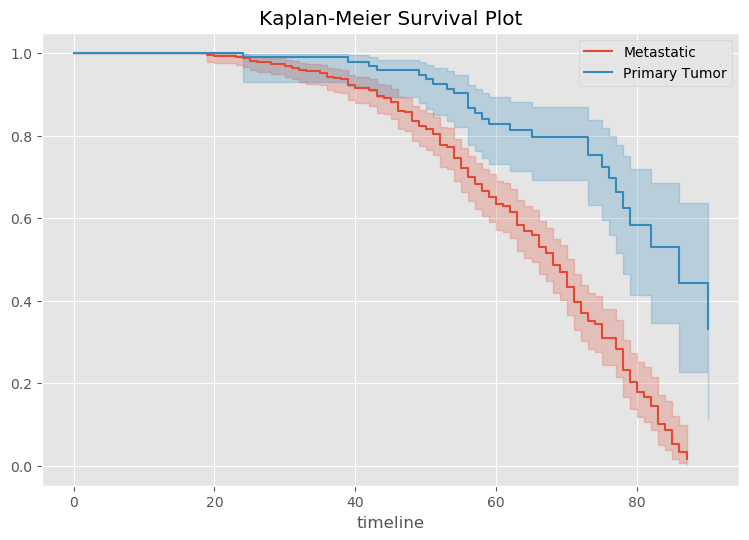

In [10]:
ax = plt.subplot(111)

T = df_.age_at_index
E = np.log(df_.C7 + 1)

metastatic = (df_["sample_type"] == "Metastatic")


kmf.fit(T[metastatic], event_observed=E[metastatic], label="Metastatic")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~metastatic], event_observed=E[~metastatic], label="Primary Tumor")
kmf.plot_survival_function(ax=ax)

plt.title("Kaplan-Meier Survival Plot");

## Logrank Test

In [11]:
results = logrank_test(T[metastatic], T[~metastatic], E[metastatic], E[~metastatic], alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          36.66 <0.005     29.41

## Kaplan Meier Survival Analysis (using age_at_diagnosis)

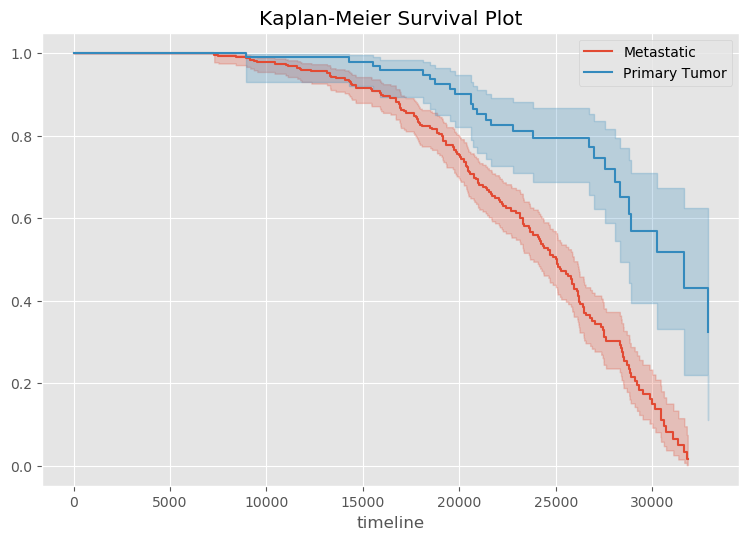

In [12]:
ax = plt.subplot(111)

T = df_.age_at_diagnosis
E = df_.vital_status

metastatic = (df_["sample_type"] == "Metastatic")


kmf.fit(T[metastatic], event_observed=E[metastatic], label="Metastatic")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~metastatic], event_observed=E[~metastatic], label="Primary Tumor")
kmf.plot_survival_function(ax=ax)

plt.title("Kaplan-Meier Survival Plot");

In [13]:
results = logrank_test(T[metastatic], T[~metastatic], E[metastatic], E[~metastatic], alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          35.88 <0.005     28.83

### Other Experiments

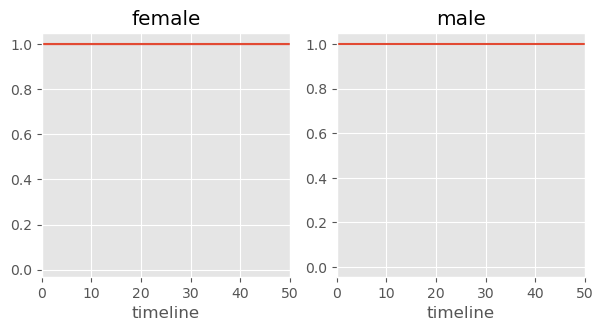

In [14]:
types = df_.gender.unique()

for i, type_ in enumerate(types):
    ax = plt.subplot(2, 3, i + 1)

    ix = df_.gender == type_
    kmf.fit(T[ix], E[ix], label=type_)
    kmf.plot_survival_function(ax=ax, legend=False)

    plt.title(type_)
    plt.xlim(0, 50)


plt.tight_layout()

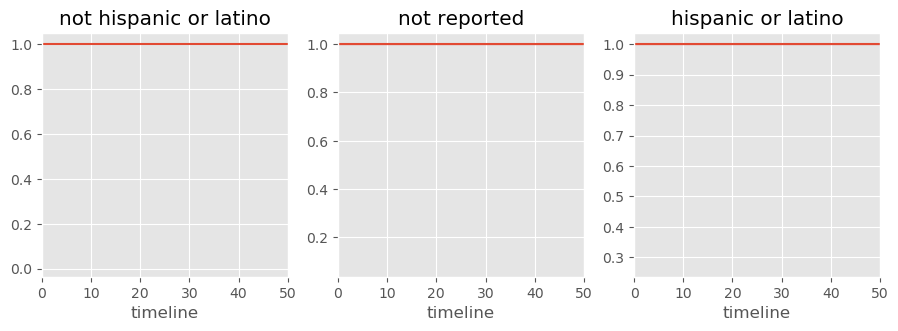

In [15]:
types = df_.ethnicity.unique()

for i, type_ in enumerate(types):
    ax = plt.subplot(2, 3, i + 1)

    ix = df_.ethnicity == type_
    kmf.fit(T[ix], E[ix], label=type_)
    kmf.plot_survival_function(ax=ax, legend=False)

    plt.title(type_)
    plt.xlim(0, 50)


plt.tight_layout()

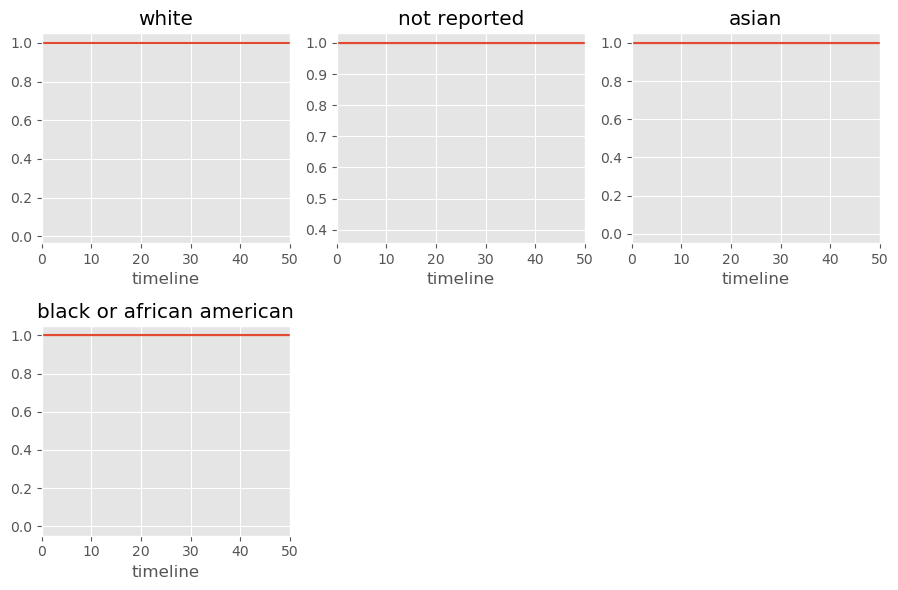

In [16]:
types = df_.race.unique()

for i, type_ in enumerate(types):
    ax = plt.subplot(2, 3, i + 1)

    ix = df_.race == type_
    kmf.fit(T[ix], E[ix], label=type_)
    kmf.plot_survival_function(ax=ax, legend=False)

    plt.title(type_)
    plt.xlim(0, 50)

plt.tight_layout()

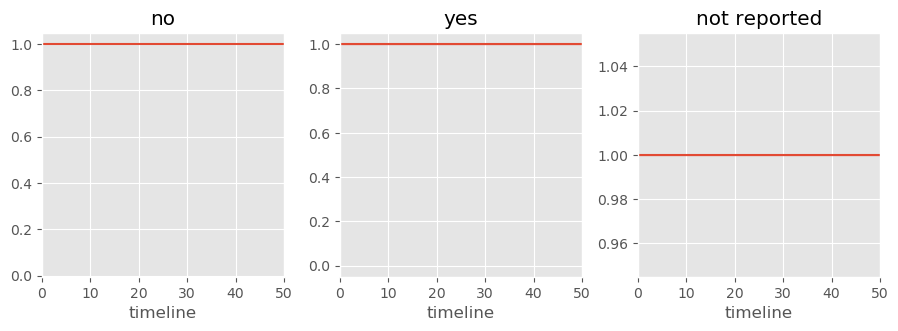

In [17]:
types = df_.treatments_radiation_treatment_or_therapy.unique()

for i, type_ in enumerate(types):
    ax = plt.subplot(2, 3, i + 1)

    ix = df_.treatments_radiation_treatment_or_therapy == type_
    kmf.fit(T[ix], E[ix], label=type_)
    kmf.plot_survival_function(ax=ax, legend=False)

    plt.title(type_)
    plt.xlim(0, 50)

plt.tight_layout()

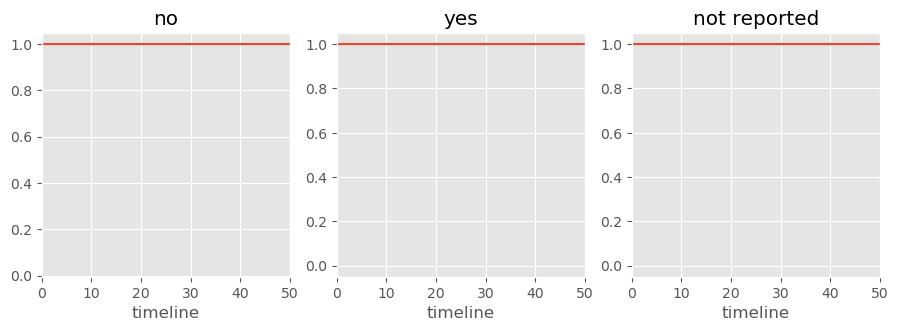

In [18]:
types = df_.treatments_pharmaceutical_treatment_or_therapy.unique()

for i, type_ in enumerate(types):
    ax = plt.subplot(2, 3, i + 1)

    ix = df_.treatments_pharmaceutical_treatment_or_therapy == type_
    kmf.fit(T[ix], E[ix], label=type_)
    kmf.plot_survival_function(ax=ax, legend=False)

    plt.title(type_)
    plt.xlim(0, 50)

plt.tight_layout()

### Next step, would be to implement Cox’s proportional hazard model similar to (Yang et al, 2018)

##### Possible references:

###### (lifelines python package) [https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html]
##### (Yang et al, 2018) [https://drive.google.com/file/d/1y0huaJlgQ54pNHhc2WX-UgsYdFMfMyUc/view?usp=sharing]